# Injection missteering: beam clone of operational BCMS (3bp) using single bunch with swapped skews settings

- hopefully this time with BPM logging on


In [1]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.10.10
Your IP is 172.17.0.24
2017-10-30 16:25:51
---


In [2]:
# let's start with the matlab data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/data/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 120 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/data/2017.10.10.11.33.02.913.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.10/data/2017.10.10.14.57.41.160.mat


## Load the data

In [3]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value',
                                                    'PI_KFA45.CCV.value'],verbose=False)

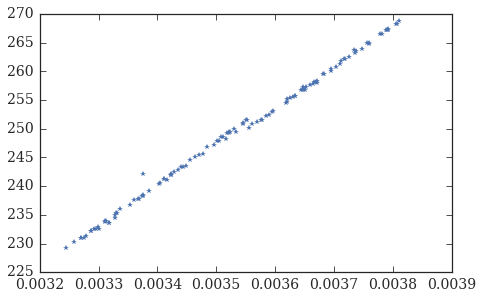

In [4]:
shiftVal=1
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')

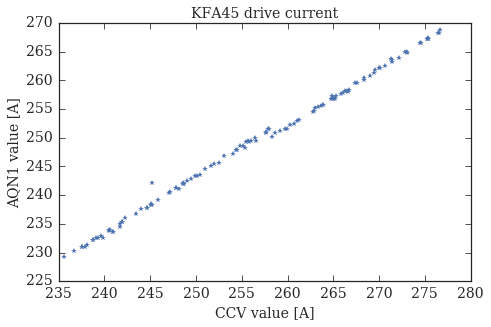

In [5]:
plt.plot(myDataFrame['PI_KFA45.CCV.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')
plt.title('KFA45 drive current')
plt.xlabel('CCV value [A]')
plt.ylabel('AQN1 value [A]')

## Measurement method:
This time the measurements are performed using a predefined array of random kicks.

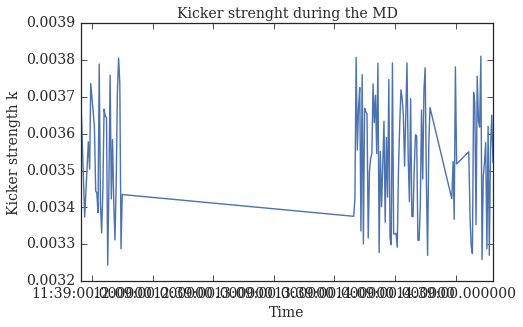

In [6]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal))
plt.xlabel('Time')
plt.ylabel('Kicker strength k')
plt.title('Kicker strenght during the MD')

## Intensity

In [7]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][105]/np.max(x) )

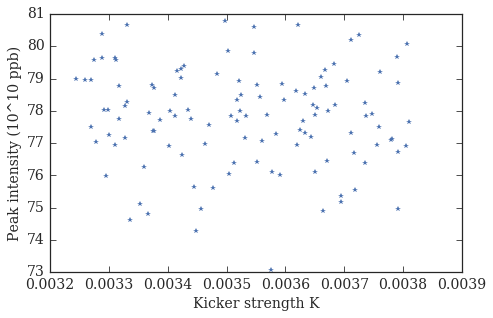

In [8]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

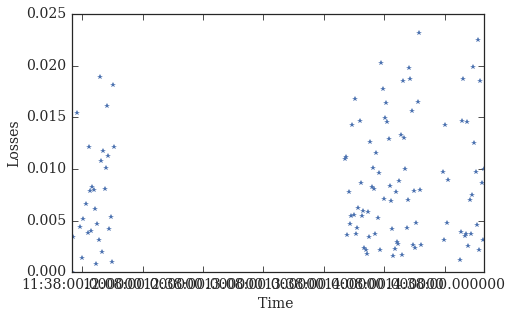

In [9]:
plt.plot(myDataFrame['Losses_perc'],'*')
x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses')

(0.0, 1500, -10.0, 90.0)

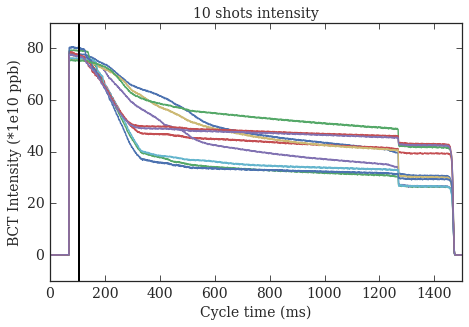

In [10]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=105, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,1500,y1,y2))

In [11]:
myDataFrame['Intensity'].values[100].max()

74.790140000000008

## BPMs

- for some reason, the second turn was not logged. The others are fine and the orbit as well. Boh ...

--> so no 1st-2nd turn difference possible

- the orbit deviation does not seem to be meaningful. 

In [12]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [13]:
## caluclate RMS orbit deviation and first two turns difference
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['OrbitX_dev_RMS'] = delta_1st_orbit

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['OrbitY_dev_RMS'] = delta_1st_orbit

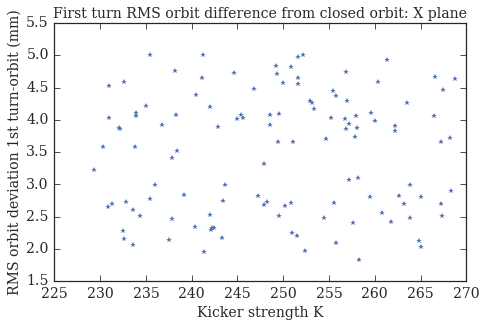

In [14]:
plt.plot(myDataFrame['PI_KFA45.AQN1.value'],myDataFrame['OrbitX_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: X plane')


x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,0,8))
#plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

(0.0032000000000000002, 0.0039000000000000003, 0.15, 0.3)

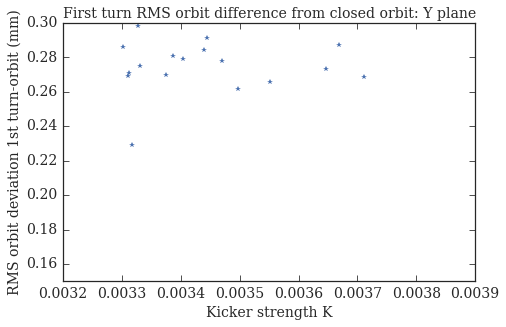

In [15]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitY_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.15,.3))
#plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

In [16]:
myDataFrame['BPMx_all_turns'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[20,:]/10.)
# myDataFrame['BPMy_all_turns'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[,:])


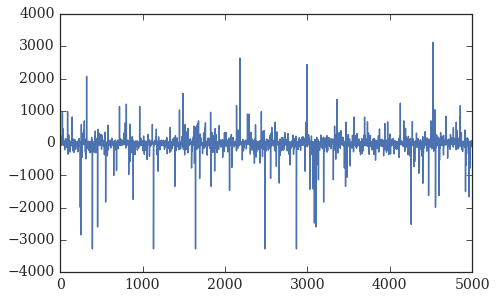

In [17]:
plt.plot(myDataFrame['BPMx_all_turns'].values[2])

In [ ]:
myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].values[0]

## Wire scanner

### X plane

In [16]:
# Data cleanup
myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-10-10 11:37:07.900000'].name)

In [17]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [18]:
#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  

/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

### Y plane

In [20]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [21]:
#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

In [22]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

### Tomogram

In [23]:
myDataFrame['peakLineDensity'] = 1.22
myDataFrame['deltaP_P_rms'] = 8.34e-4

## Emitance

In [24]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
    D = 3.24577470 #at wirescanner 65
#     betax = 13.00860302 #at wirescanner 68
    betax = 21.77988929 #at wirescanner 65
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 11.44763004 #[metres] #at wirescanner 85
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

In [25]:
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

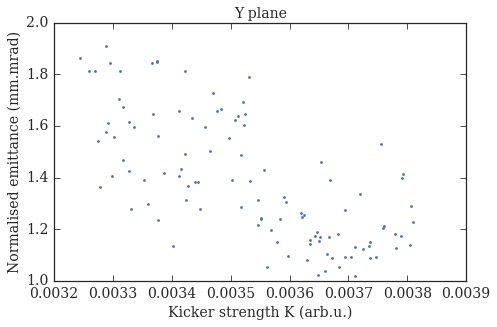

In [26]:
#bunched
Bunched_y, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.', label='Bunched')
plt.xlabel('Kicker strength K (arb.u.)')
plt.ylabel('Normalised emittance (mm.mrad)')

plt.title('Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2))

plt.show()

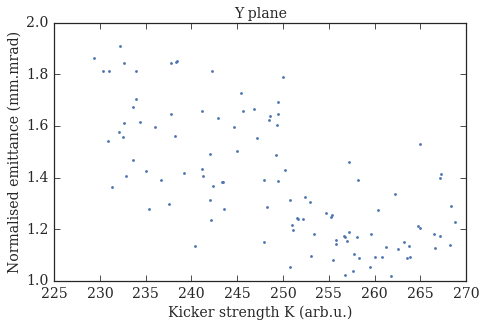

In [27]:
#bunched
Bunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'],myDataFrame['WS_emittance_y'],'.', label='Bunched')
plt.xlabel('Kicker strength K (arb.u.)')
plt.ylabel('Normalised emittance (mm.mrad)')

plt.title('Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2))

plt.show()

### X plane

In [28]:
myDataFrame['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame['WS_sigma_x'].values[n],myDataFrame['deltaP_P_rms'].values[n])

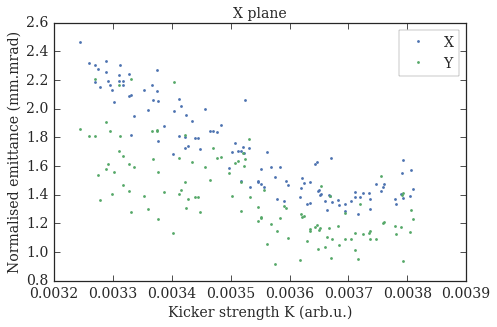

In [29]:
#bunched
Bunched_x, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.', label='X')
plt.xlabel('Kicker strength K (arb.u.)')
plt.ylabel('Normalised emittance (mm.mrad)')
Bunched_y, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.', label='Y')


plt.title('X plane')

legend = plt.legend(handles=[Bunched_x,Bunched_y],frameon=True)



x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))
plt.show()

## Comparison to theory

Model function: a(x - b)^2 + c
Fit params: a=3.52066240386 b= 0.00378116411221 c= 1.39713305038e-06


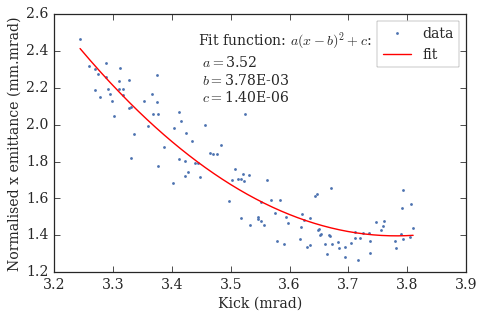

In [30]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal)[1:]
ydata = 1e-6*myDataFrame['WS_emittance_x'].values[1:]

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='data') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('Kick (mrad)')
plt.ylabel('Normalised x emittance (mm.mrad)')
plt.legend(frameon=True)

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

## Laslett tune shift

In [31]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [32]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

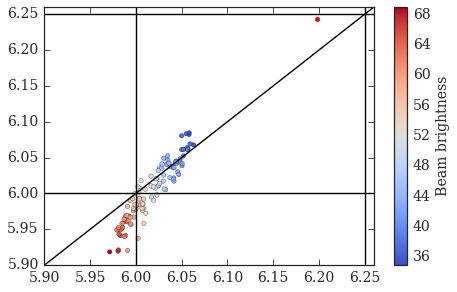

In [33]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.198
Qy = 6.244
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([5.9, 6.26])
plt.ylim([5.9, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

plt.show()

fig.savefig('BCMS_no_coupling_footprint.eps', format='eps')

Shifted x tune threshold < 6.198
Shifted y tune threshold < 6.244


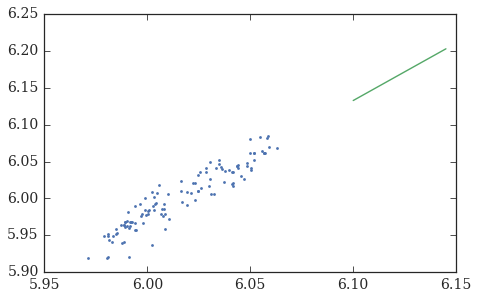

In [36]:
# linear fitting of the data
Qx_thr = -0
Qy_thr = -0
print 'Shifted x tune threshold < '+str(Qx+Qx_thr)
print 'Shifted y tune threshold < '+str(Qy+Qy_thr)

dQx = Qx + myDataFrame['deltaQx'].loc[(myDataFrame['deltaQx'] < Qx_thr) & (myDataFrame['deltaQy'] < Qy_thr)]
dQy = Qy + myDataFrame['deltaQy'].loc[(myDataFrame['deltaQx'] < Qx_thr) & (myDataFrame['deltaQy'] < Qy_thr)]
plt.plot(dQx,dQy,'.')

# the fit
param = np.polyfit(dQx,dQy,1)
x = np.linspace(6.1,6.145,100)
plt.plot(x,param[0]*x+param[1])


In [38]:
param

# print "multiplying by 4 it is: 4Qx - 4Qy = 1"

array([ 1.55806063, -3.37138833])

## Export the data

In [34]:
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[85])

In [35]:
myDataFrame[['WS_intensity','logical_PI_KFA45.K.value','peakLineDensity','WS_emittance_x','WS_emittance_y','deltaP_P_rms']].to_csv('dataFrameExported.csv')